In [1]:
! pip install pandas numpy scikit-learn statsmodels arch 
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime
from sklearn.decomposition import FastICA
from statsmodels.tsa.stattools import adfuller
import arch
import warnings

warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_excel("dataset.xlsx")

In [3]:
dataset.rename(columns={'close_BBG0000776S2': 'close_B_1', 'close_BBG00B9PJ7V0': 'close_B_2', 'close_BBG00D6Q7LY6': 'close_B_3',\
                   'close_BBG00K53FBX6': 'close_B_4', 'close_BBG00R0Z4YW8': 'close_B_5',\
                   'coupon_BBG0000776S2': 'coupon_1', 'coupon_BBG00B9PJ7V0': 'coupon_2', 'coupon_BBG00D6Q7LY6': 'coupon_3',\
                   'coupon_BBG00K53FBX6': 'coupon_4', 'coupon_BBG00R0Z4YW8': 'coupon_5' }, inplace=True)

In [4]:
critical_columns = ['close_B_1', 'close_B_2', 'close_B_3', 'close_B_4', 'close_B_5',
       'close_AFKS', 'close_AGRO', 'close_BRENT', 'close_EUR_RUB__TOD',
       'close_GAZP', 'close_IMOEX', 'close_LKOH', 'close_NLMK', 'close_NVTK',
       'close_PLZL', 'close_ROSN', 'close_RTKM', 'close_RTSI', 'close_SBER',
       '%_0,25y', '%_0,5y', '%_0,75y', '%_1y', '%_2y',
       '%_3y', '%_5y', '%_7y', '%_10y', '%_15y', '%_20y', '%_30y']

В качестве риск-факторов м ывзяли цены закрытия ценных бумаг и валютных курсов доллара и  евро, что очевидно является риск-факторами нашего портфеля. Также мы взяли индексы российской фондовой биржи, как агрегирующие риск-факторы общего инвестиционного фона ФР, котировки нефти, от которых зависят как некоторые тикеры портфеля, так и  макроэкономика России, и ставки КБД по основным тенорам - риск-факторы процентных  ставок. Также мы учли и купоны по бондам, которые нужно будет продисконтировать что мы и сделаем ниже

In [5]:
print(len(dataset))
dataset = dataset.dropna(subset = critical_columns)
print(len(dataset))

1131
949


У нас есть столбцы купонов - которые конечно же влияют на стоимость облигаций. Давайте на каждую дату для каждой облигации посчитаем дисконтированную сумму купонов. По-хорошему, надо было для длинных бондов достать купоны вплоть до погашения - но мы немножко это опустим на милость проверяющего, дело ведь в технике исполнения а не мелочах)) Каждый купон будет продисконтирован по своему тенору КБД в зависимости от близости выплаты к рассматриваемой дате.

In [6]:
coupon_columns = ['coupon_1', 'coupon_2', 'coupon_3', 'coupon_4', 'coupon_5']
for col in coupon_columns:
    dataset[col] = dataset[col].replace([None], 0)
dataset.index = [i for i in range(len(dataset))]

In [7]:
def calculate_discounted_coupons(df, coup_col):
    res_col = []
    for index, row in df.iterrows():
        if index !=  len(df) -1 :
            diff_days = df['dt'].apply(lambda x: (x - row['dt']).days)
            mask = diff_days > 0 
            mask_1 = (0 < diff_days) & (diff_days <= 90)
            mask_2 = (90 < diff_days) & (diff_days <= 180)
            mask_3 = (180 < diff_days) & (diff_days <= 365)
            mask_4 = (365 < diff_days) & (diff_days <= 365*2)
            mask_5 = (365*2 < diff_days) & (diff_days <= 365*3)
            mask_6 = (365*3 < diff_days) & (diff_days <= 365*4)
            total_discount = (df[coup_col]* mask*((mask_1 / (1 + row['%_0,25y'] / 365/100 )**(diff_days/365)) + \
                                                        (mask_2 / (1 + row['%_0,5y'] / 365/100 )**(diff_days/365)) +\
                                                        (mask_3 / (1 + row['%_1y'] / 365/100 )**(diff_days/365)) +\
                                                        (mask_4 / (1 + row['%_2y'] / 365/100 )**(diff_days/365)) +\
                                                        (mask_5 / (1 + row['%_3y'] / 365/100 )**(diff_days/365)) +\
                                                        (mask_6 / (1 + row['%_5y'] / 365/100 )**(diff_days/365))\
                                                        )).sum()
        else: 
            total_discount = np.nan
        res_col.append(total_discount)
    df[f'discounted_{coup_col}'] = res_col
    # находим среднее значение столбца col без учета пропущенных значений и нулей
    col = f'discounted_{coup_col}'
    mean_value = df.loc[~df[col].isin([None, 0]), col].mean()

    # заполняем пропущенные значения и нули средним
    df[col] = df[col].replace([None, 0], mean_value)
    return df

In [8]:
for coup_col in coupon_columns:
    dataset = calculate_discounted_coupons(dataset, coup_col)

In [9]:
# больше нам не нужны столбцы купонов
cols_to_drop = ['coupon_1', 'coupon_2', 'coupon_3', 'coupon_4', 'coupon_5']
dataset = dataset.drop(columns=cols_to_drop)

In [10]:
print(len(dataset))
dataset = dataset.dropna()
print(len(dataset))

949
916


In [11]:
dataset.tail(2)

,dt,close_B_1,close_B_2,close_B_3,close_B_4,close_B_5,close_AFKS,close_AGRO,close_BRENT,close_EUR_RUB__TOD,...,%_7y,%_10y,%_15y,%_20y,%_30y,discounted_coupon_1,discounted_coupon_2,discounted_coupon_3,discounted_coupon_4,discounted_coupon_5
946,2023-12-27,705.98,844.40,917.48,818.22,837.4,16.054,1384.0,79.66,101.345,...,12.02,12.03,12.05,12.05,12.05,142.329043,179.452442,140.285598,151.176149,127.164799
947,2023-12-28,707.92,844.11,919.28,818.90,842.5,15.897,1367.0,77.53,99.800,...,11.84,11.80,11.74,11.68,11.62,142.329043,179.452442,140.285598,151.176149,127.164799


In [12]:
financial_columns = ['close_B_1', 'close_B_2', 'close_B_3', 'close_B_4', 'close_B_5',\
       'close_AFKS', 'close_AGRO', 'close_BRENT', 'close_EUR_RUB__TOD',\
       'close_GAZP', 'close_IMOEX', 'close_LKOH', 'close_NLMK', 'close_NVTK',\
       'close_PLZL', 'close_ROSN', 'close_RTKM', 'close_RTSI', 'close_SBER',\
       'close_USD000000TOD', '%_0,25y', '%_0,5y', '%_0,75y', '%_1y', '%_2y',\
       '%_3y', '%_5y', '%_7y', '%_10y', '%_15y', '%_20y', '%_30y'
       # ,\
       # 'discounted_coupon_1', 'discounted_coupon_2', 'discounted_coupon_3',\
       # 'discounted_coupon_4', 'discounted_coupon_5'
       ]
len(financial_columns)

32

Теперь сохраним датасет с полученными фичами

In [13]:
dataset.to_excel('dataset_coupons.xlsx', index = False)

Одной из альтернативных методов для снижения размерности данных, помимо метода главных компонент (PCA), является метод независимых компонент (Independent Component Analysis, ICA). Ниже приведены некоторые особенности метода ICA:

1. **Независимость компонент**: В отличие от PCA, который находит ортогональные компоненты (главные компоненты) с максимальной дисперсией, ICA стремится найти компоненты, которые являются независимыми друг от друга. Это позволяет выявить скрытые структуры данных, которые могут быть связаны с различными источниками.

2. **Способность к разделению источников**


3. **Робастность к негауссовским данным**

4. **Интерпретируемость компонент**

ICA может быть использован для разделения смешанных временных рядов, таких как цены акций или валютных курсов, на независимые составляющие. Это может помочь выявить скрытые структуры и зависимости между различными финансовыми инструментами.

То, что нужно!

In [14]:
def get_risk_factors(dt_end = datetime.date(2023 , 12, 3), dataset = dataset, financial_columns = financial_columns):
    dt_end_datetime = pd.to_datetime(dt_end)
    # Фильтрация DataFrame по условию dt < dt_end
    dataset = dataset[dataset['dt'] < dt_end_datetime].reset_index().drop(columns = ['index'])
    df_financial = dataset[financial_columns]

    # Инициализация модели ICA
    ica = FastICA(n_components=10, algorithm='parallel', whiten=True, fun='logcosh', max_iter=300)

    # подгонка модели к данным и извлечение независимых компонент
    ica_components = ica.fit_transform(df_financial)

    # создание нового DataFrame с независимыми компонентами как столбцами
    df_ica = pd.DataFrame(data=ica_components)

    # вывод результата
    df_ica.columns = [f'risk_factor_{i}' for i in range(len(df_ica.columns))]
    df_ica['dt'] = dataset['dt']
    df_ica = df_ica[['dt'] +[f'risk_factor_{i}' for i in range(len(df_ica.columns)-1)]]
    # Объясненная дисперсия для каждой компоненты
    dataset = dataset.merge(df_ica, how = 'left', on = 'dt')

    return dataset


In [15]:
df_risks = get_risk_factors(dt_end = datetime.date(2023 , 12, 3), dataset = dataset)

In [16]:
df_risks.tail(2)

,dt,close_B_1,close_B_2,close_B_3,close_B_4,close_B_5,close_AFKS,close_AGRO,close_BRENT,close_EUR_RUB__TOD,...,risk_factor_0,risk_factor_1,risk_factor_2,risk_factor_3,risk_factor_4,risk_factor_5,risk_factor_6,risk_factor_7,risk_factor_8,risk_factor_9
897,2023-11-30,715.71,850.35,921.5,825.62,845.29,16.126,1449.0,81.25,96.8225,...,0.153191,-0.003419,-0.033702,0.027301,0.010126,-0.012066,-0.017325,0.026846,0.008245,0.018948
898,2023-12-01,712.55,846.99,916.2,823.88,836.50,15.911,1422.4,79.43,97.8825,...,0.146404,-0.001732,-0.030835,0.026275,0.014176,-0.016539,-0.008013,0.021763,0.005455,0.017331


In [17]:
df = df_risks[[f'risk_factor_{i}' for i in range(10)]].copy()
df.index = df_risks['dt']

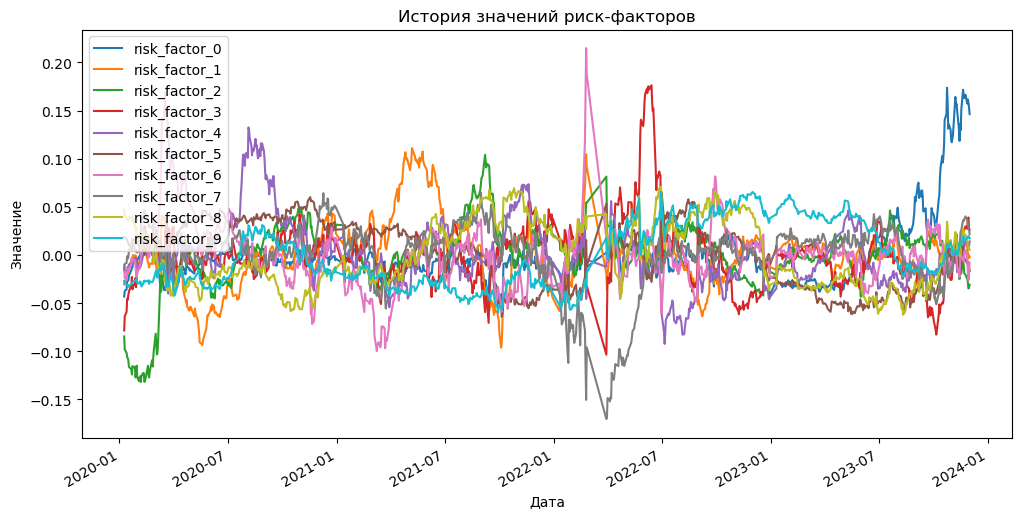

       risk_factor_0  risk_factor_1  risk_factor_2  risk_factor_3  \
count   8.990000e+02   8.990000e+02   8.990000e+02   8.990000e+02   
mean    2.469907e-18   1.407847e-17   5.334998e-17   1.926527e-17   
std     3.337043e-02   3.337043e-02   3.337043e-02   3.337043e-02   
min    -5.288082e-02  -9.616879e-02  -1.318159e-01  -1.034252e-01   
25%    -1.509037e-02  -1.513946e-02  -1.246833e-02  -1.933054e-02   
50%    -5.362155e-03   2.274438e-04   4.001772e-03  -1.376736e-03   
75%     3.494861e-03   1.312459e-02   1.629194e-02   1.409879e-02   
max     1.737689e-01   1.110860e-01   1.041054e-01   1.763662e-01   

       risk_factor_4  risk_factor_5  risk_factor_6  risk_factor_7  \
count   8.990000e+02   8.990000e+02   8.990000e+02   8.990000e+02   
mean    1.284351e-17  -1.975925e-17   4.890415e-17   8.101294e-17   
std     3.337043e-02   3.337043e-02   3.337043e-02   3.337043e-02   
min    -9.230817e-02  -6.417076e-02  -9.969727e-02  -1.702464e-01   
25%    -1.943711e-02  -3.317766e-

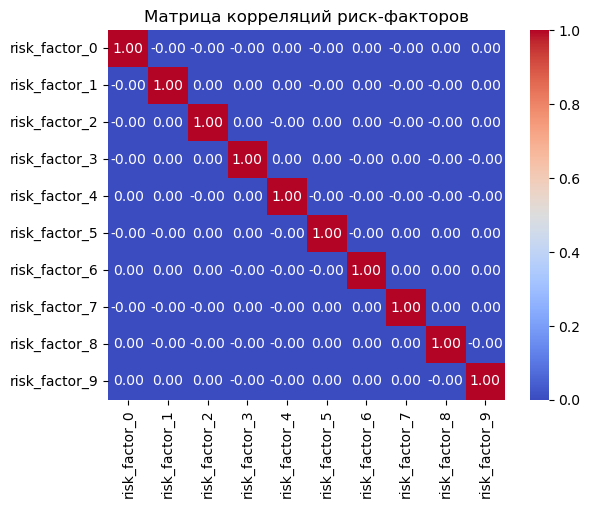

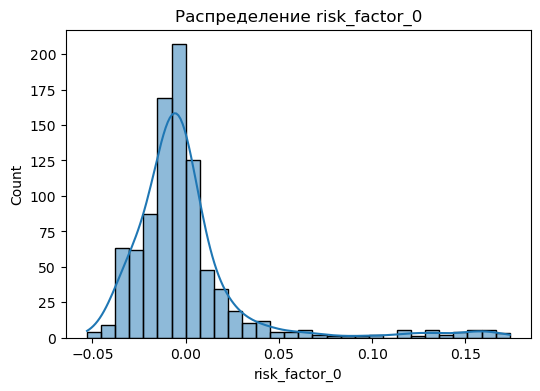

Риск-фактор: risk_factor_0; skewness: 2.991500462862878; kurtosis: 10.846802026442685


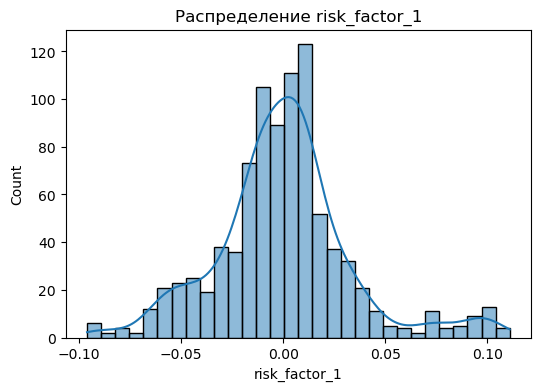

Риск-фактор: risk_factor_1; skewness: 0.5060371029306571; kurtosis: 1.6285663965589907


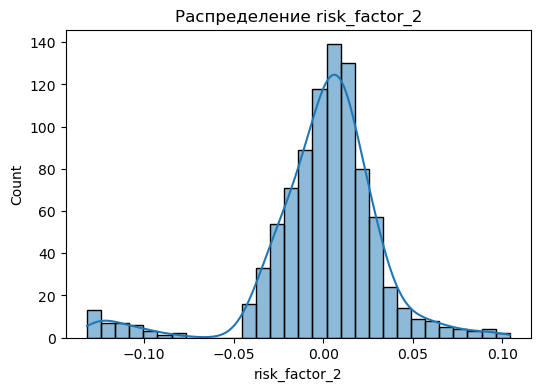

Риск-фактор: risk_factor_2; skewness: -1.3881592652710064; kurtosis: 4.735513511317871


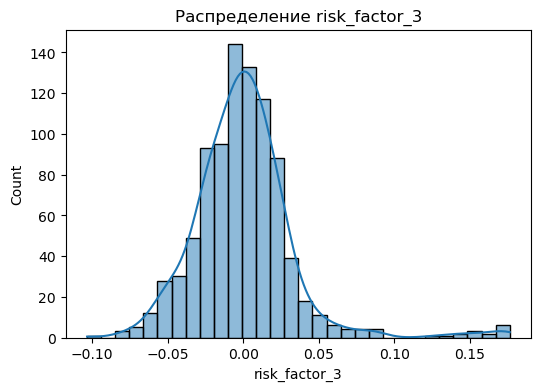

Риск-фактор: risk_factor_3; skewness: 1.6915671669556496; kurtosis: 7.377753399655246


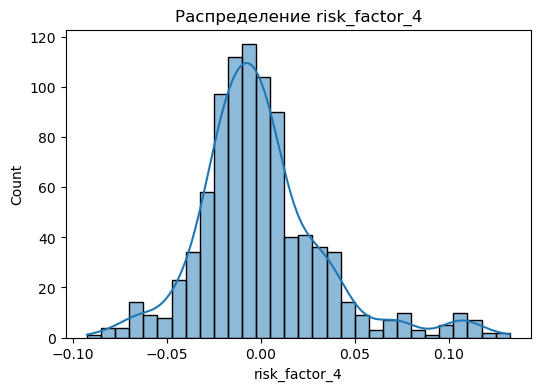

Риск-фактор: risk_factor_4; skewness: 1.0314796740007481; kurtosis: 2.3849248714681717


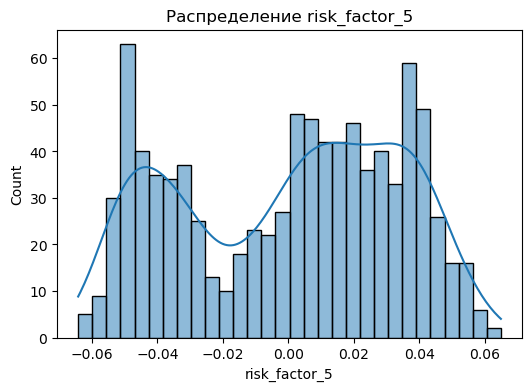

Риск-фактор: risk_factor_5; skewness: -0.19807540304828522; kurtosis: -1.2493668228362595


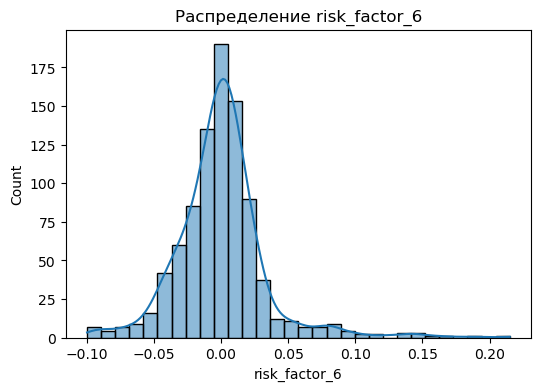

Риск-фактор: risk_factor_6; skewness: 1.2856518675888955; kurtosis: 6.428850733285822


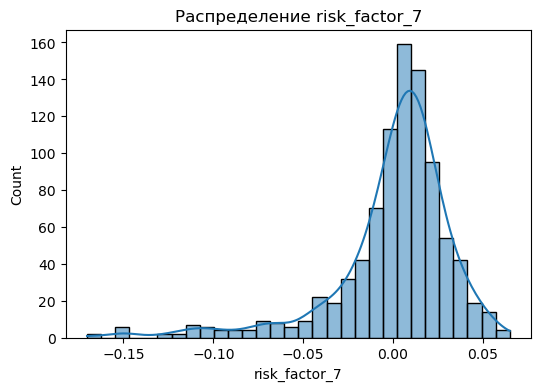

Риск-фактор: risk_factor_7; skewness: -1.9286140736660695; kurtosis: 5.353519824361555


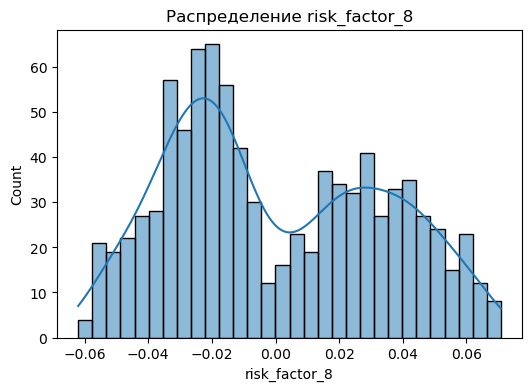

Риск-фактор: risk_factor_8; skewness: 0.2613378991720528; kurtosis: -1.1015785693397826


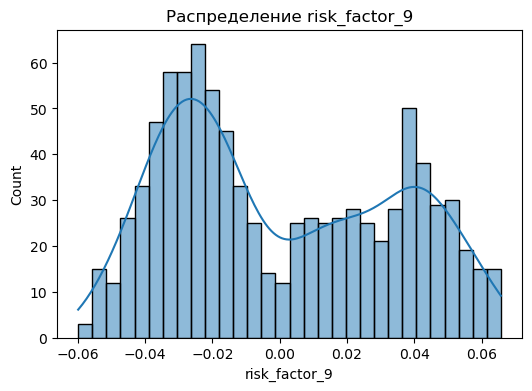

Риск-фактор: risk_factor_9; skewness: 0.28120614853777703; kurtosis: -1.2562138787397448


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
df.plot(figsize=(12, 6))  # Предполагается, что столбцы содержат временные данные и риск-факторы
plt.title('История значений риск-факторов')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.show()

# Описательная статистика
description = df.describe()
print(description)

# Корреляции риск-факторов
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляций риск-факторов')
plt.show()

# "Тяжесть хвостов" распределения
for column in df.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f'Распределение {column}')
    plt.show()

    skew = df[column].skew()
    kurtosis = df[column].kurtosis()
    print(f'Риск-фактор: {column}; skewness: {skew}; kurtosis: {kurtosis}')

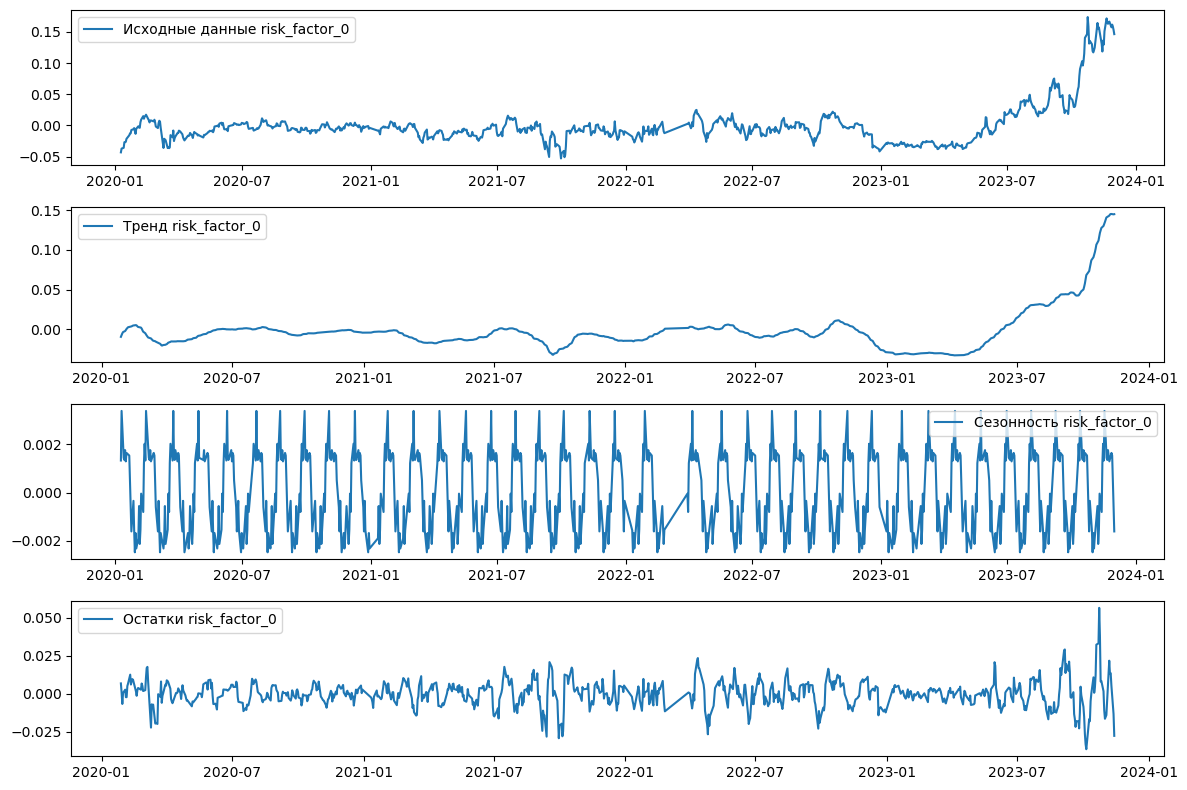

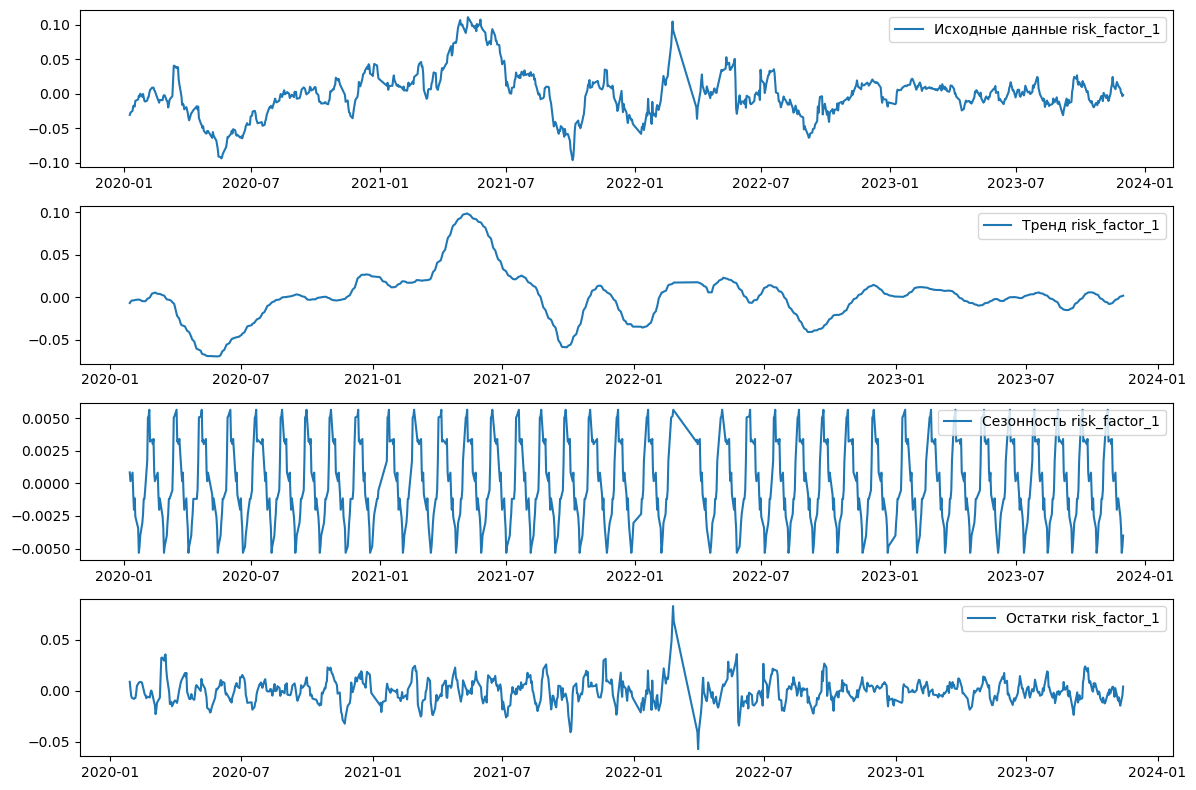

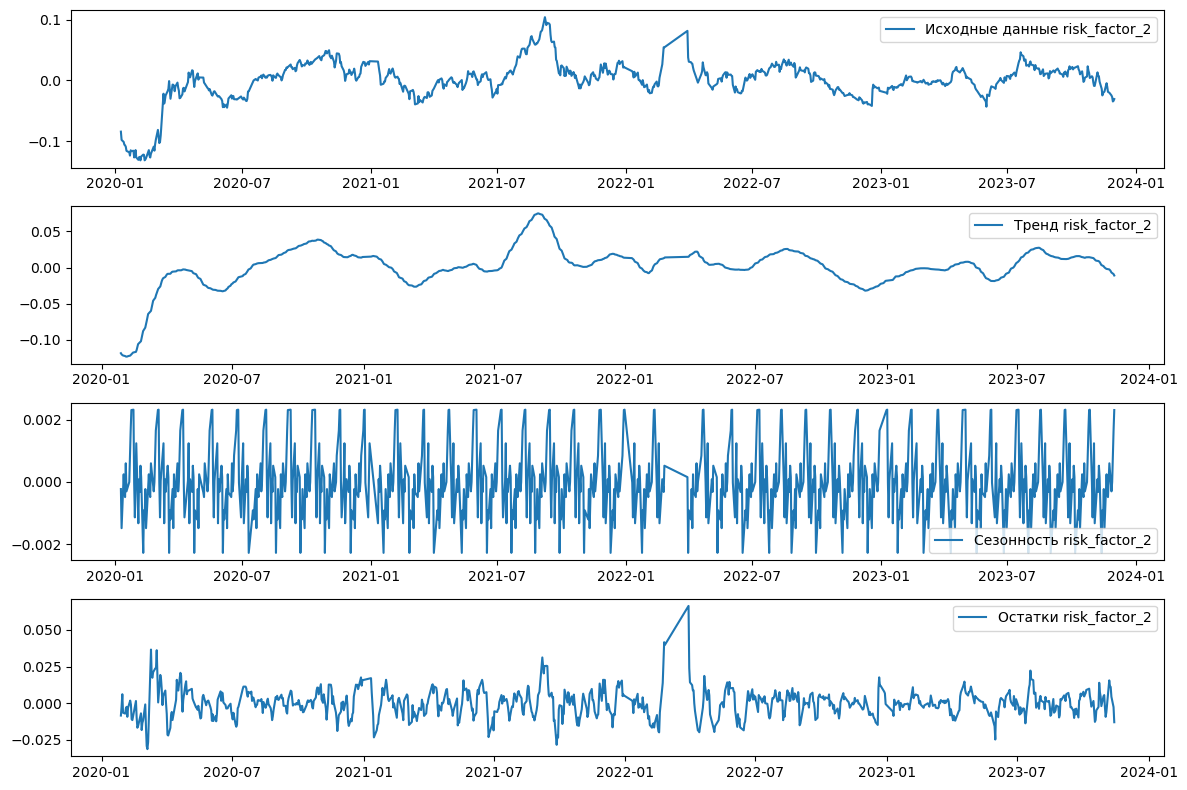

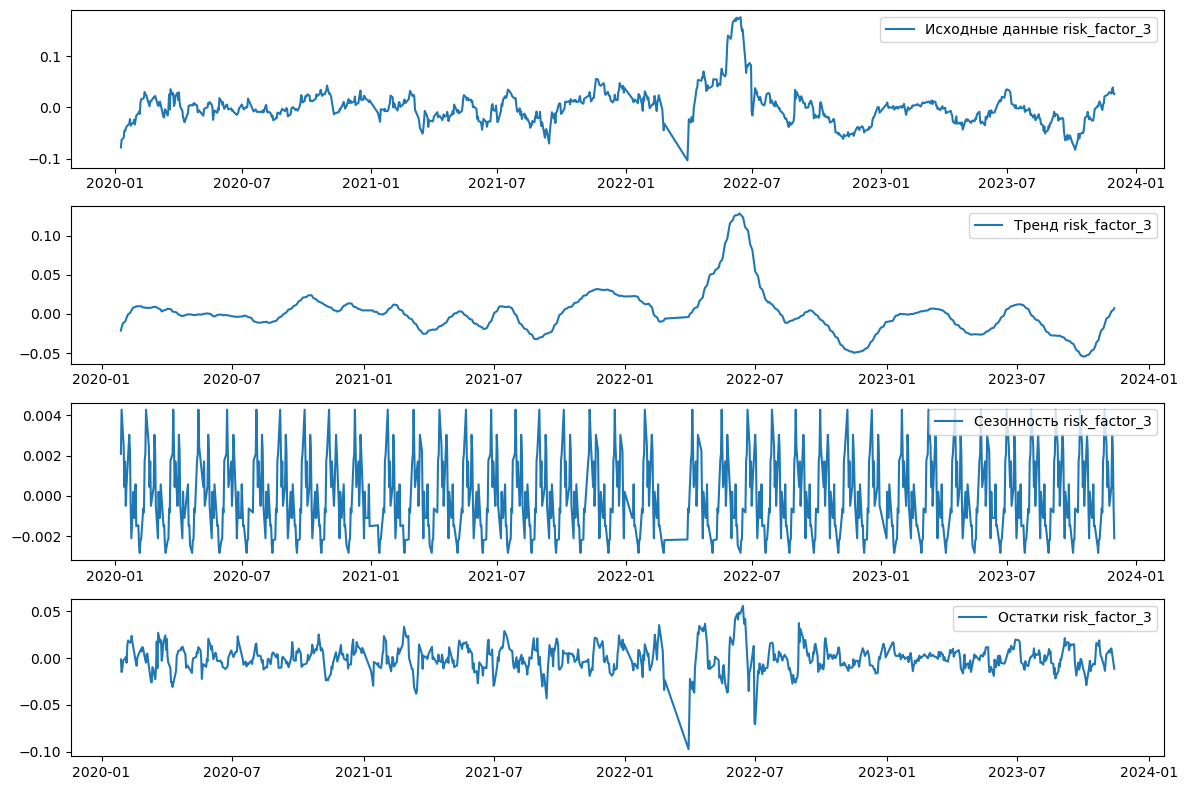

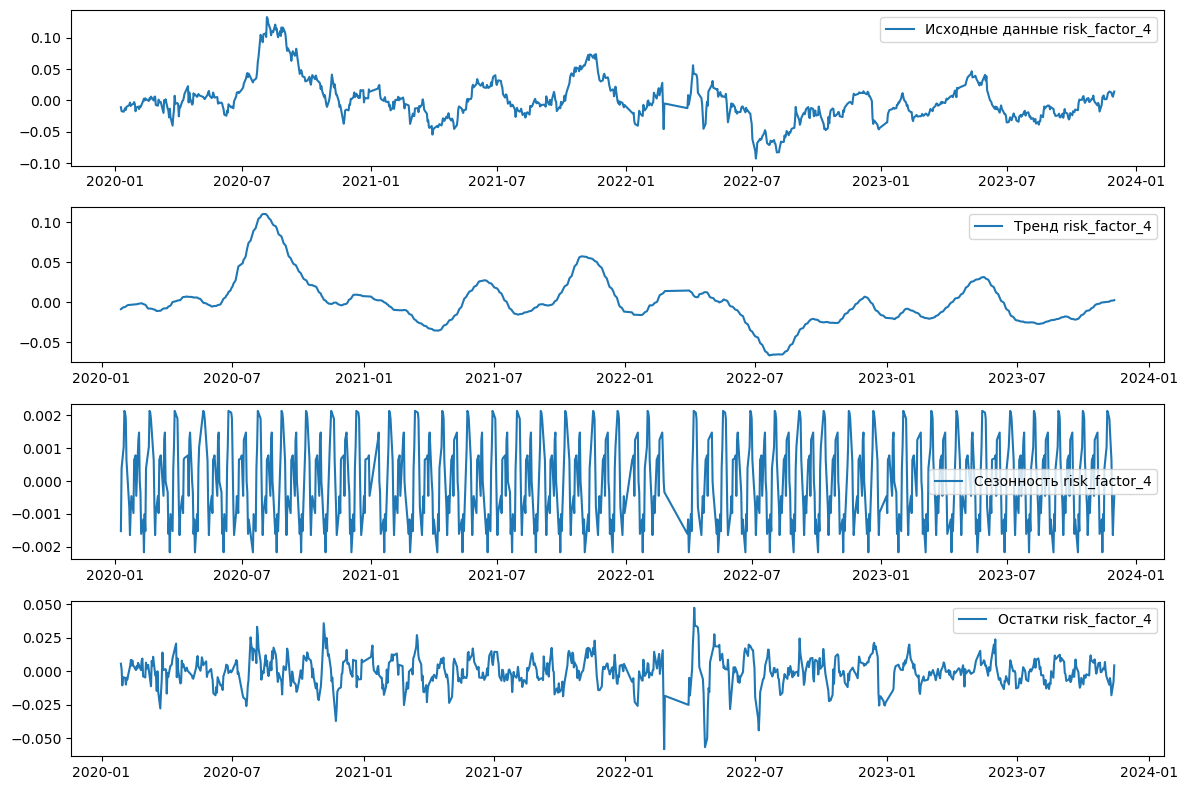

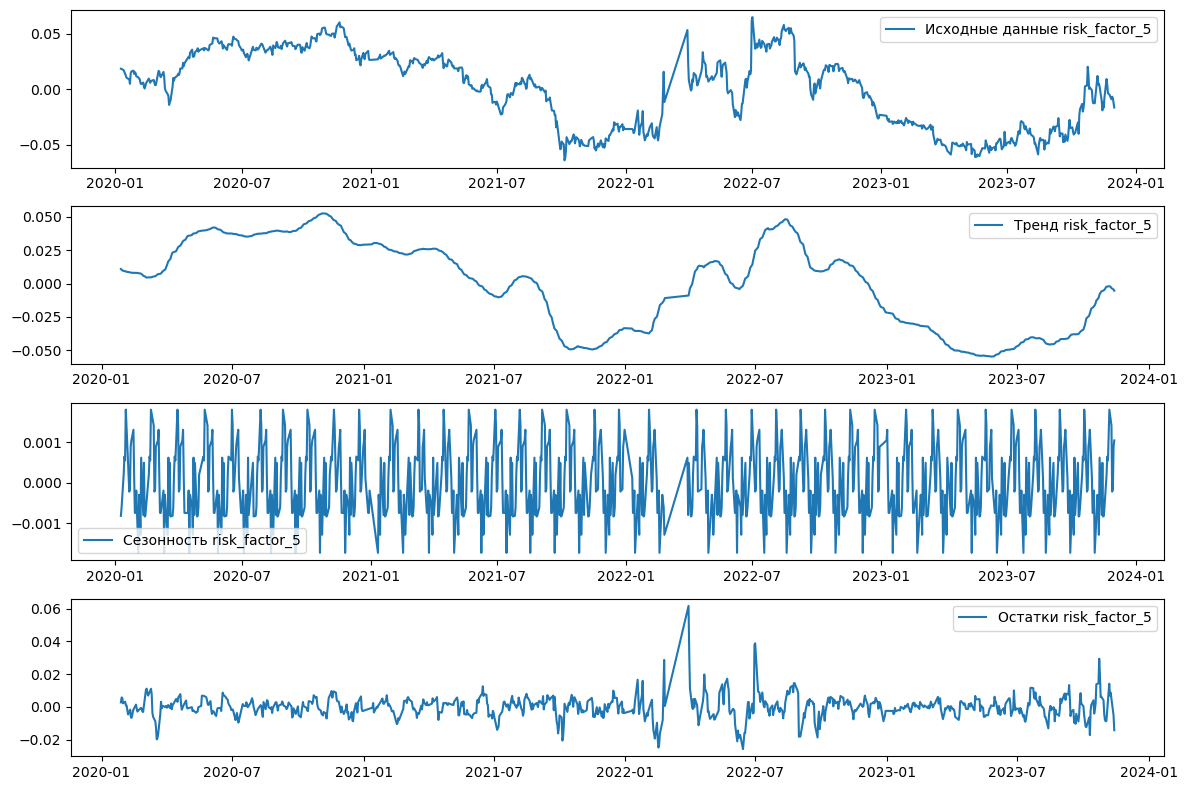

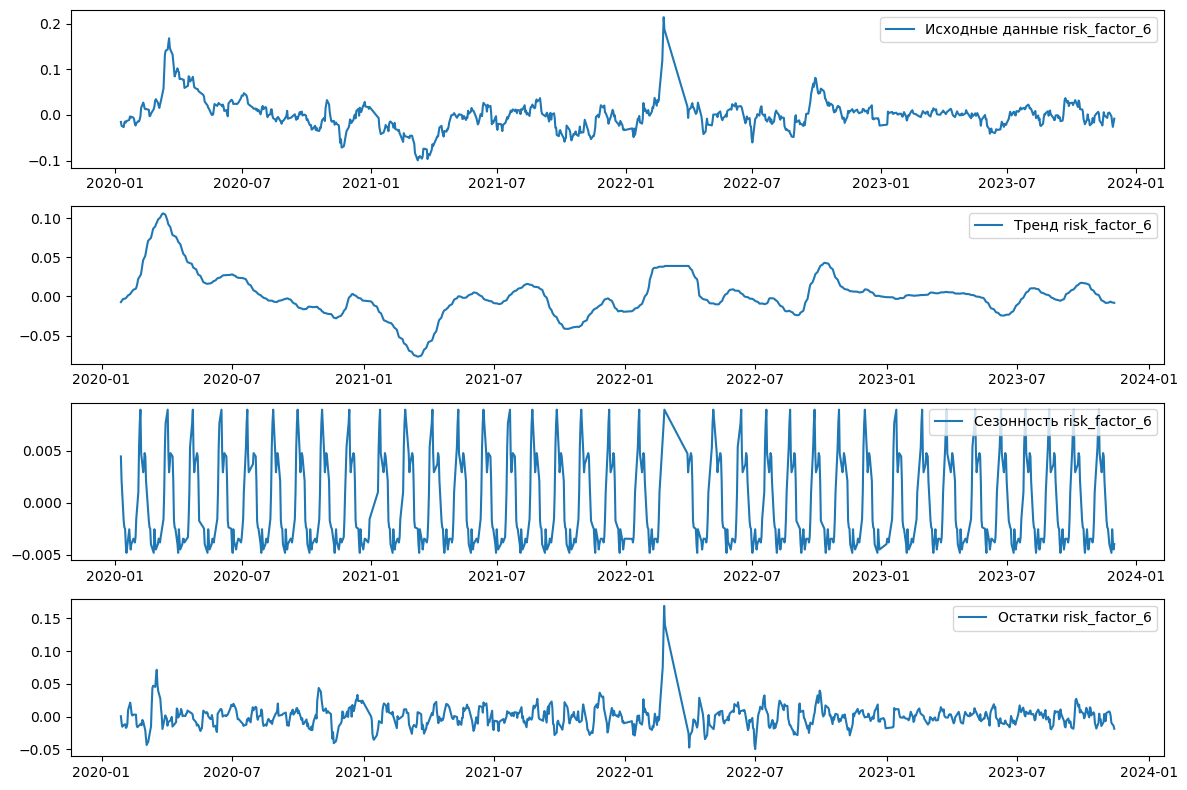

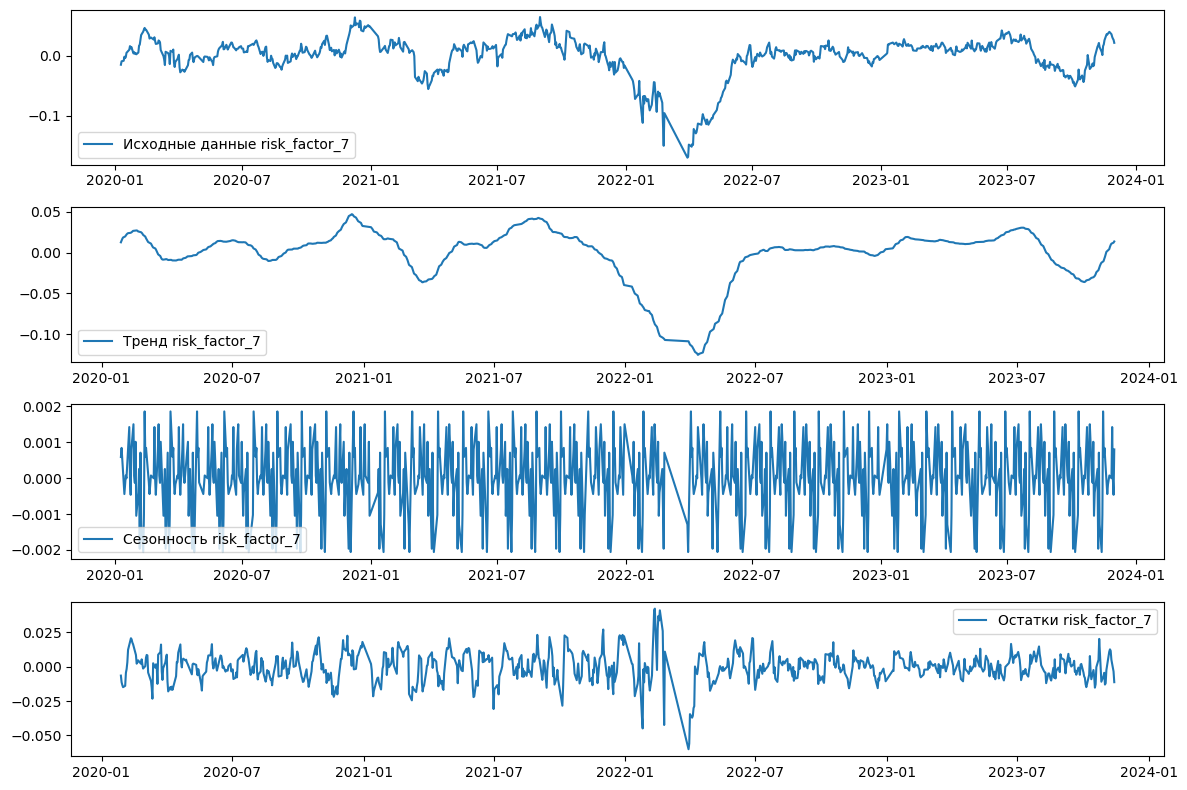

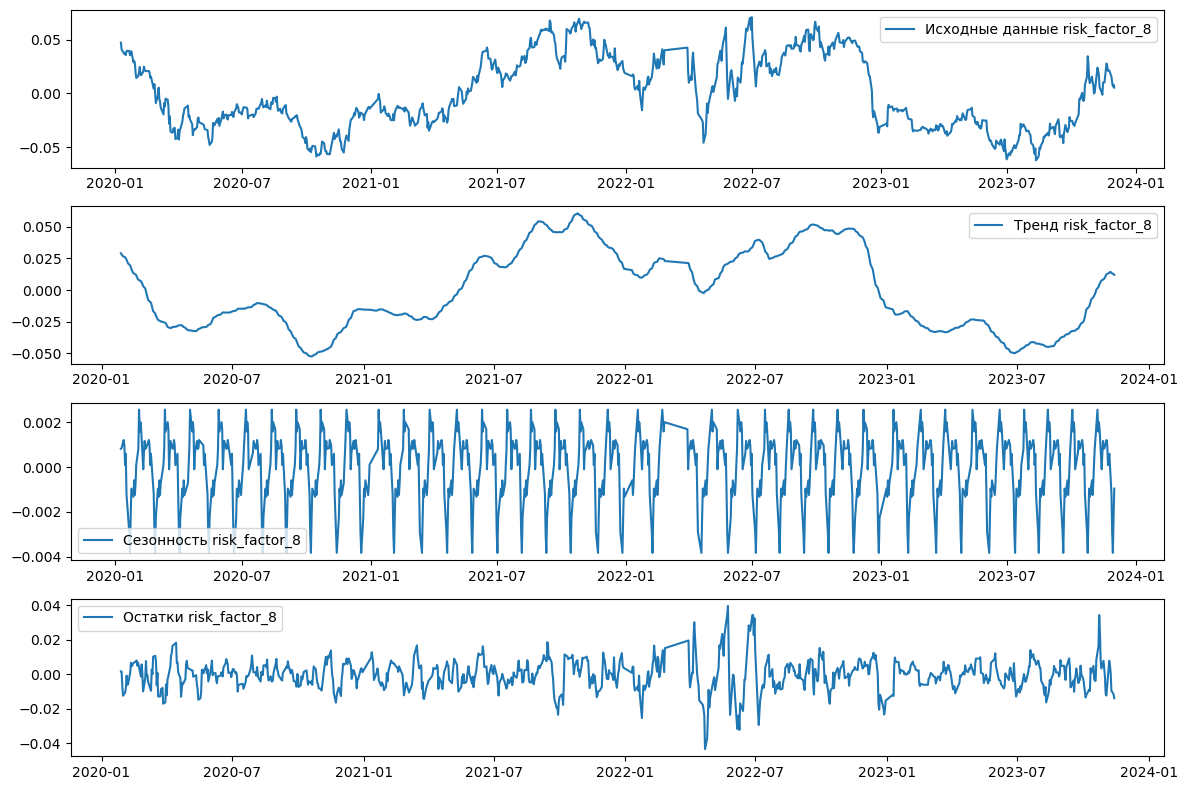

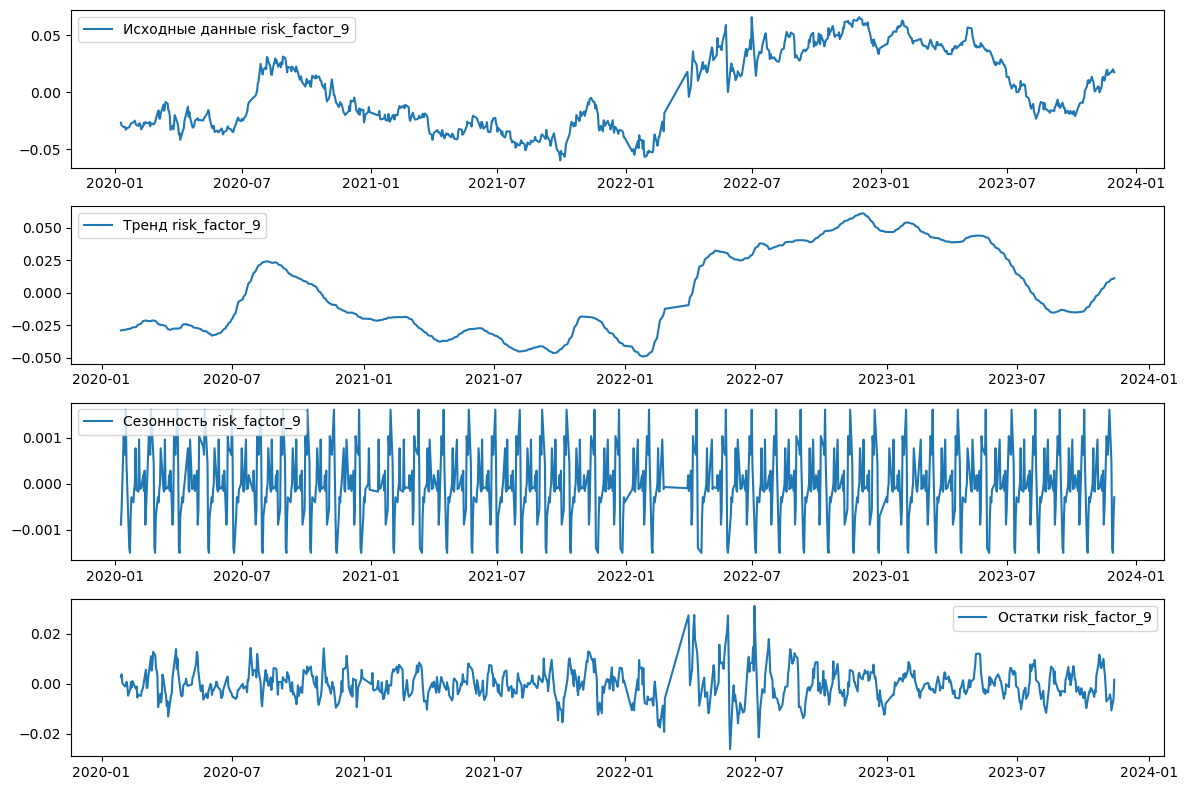

In [19]:
for column in df.columns:
    decomposition = seasonal_decompose(df[column], model='additive', period=24)  # Предполагается, что есть сезонность

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(df[column], label=f'Исходные данные {column}')
    plt.legend()

    plt.subplot(412)
    plt.plot(trend, label=f'Тренд {column}')
    plt.legend()

    plt.subplot(413)
    plt.plot(seasonal, label=f'Сезонность {column}')
    plt.legend()

    plt.subplot(414)
    plt.plot(residual, label=f'Остатки {column}')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [20]:
for column in df.columns:
    result = adfuller(df[column])
    print(f'Тест на стационарность для столбца {column}:')
    print(f'ADF статистика: {result[0]}')
    print(f'p-значение: {result[1]}')
    print('Критические значения:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

    if result[1] <= 0.05:
        print(f'Результат: Ряд стационарен на уровне значимости 0.05')
    else:
        print('Результат: Ряд нестационарен')
    print()

Тест на стационарность для столбца risk_factor_0:
ADF статистика: -1.272305532618143
p-значение: 0.6417454286272364
Критические значения:
	1%: -3.4376529968296987
	5%: -2.8647639026442993
	10%: -2.5684866236774617
Результат: Ряд нестационарен

Тест на стационарность для столбца risk_factor_1:
ADF статистика: -3.800601634972828
p-значение: 0.0029011654753944662
Критические значения:
	1%: -3.43771883253448
	5%: -2.8647929301713977
	10%: -2.568502085595253
Результат: Ряд стационарен на уровне значимости 0.05

Тест на стационарность для столбца risk_factor_2:
ADF статистика: -3.5776108414069436
p-значение: 0.006203772011587209
Критические значения:
	1%: -3.4376529968296987
	5%: -2.8647639026442993
	10%: -2.5684866236774617
Результат: Ряд стационарен на уровне значимости 0.05

Тест на стационарность для столбца risk_factor_3:
ADF статистика: -4.934229634060086
p-значение: 2.9900982788031978e-05
Критические значения:
	1%: -3.4376529968296987
	5%: -2.8647639026442993
	10%: -2.5684866236774617

По многим риск-факторам не наблюдается стационарность. Более того, явно видны периоды когда волатильность риск-факторов растёт (кластеризуется) (графики истории значений риск-факторов и графики остатков при декомпозиции ряда). Тогда применим для  них AR-GARCH-модель. Используем библиотеку arch, его дефолтный метод fitа - ММП. Так как мы использовали ICA - можно использовать univariate models - ведь риск-факторы получены независимыми друг от друга. И модель можно фиить для каждого риск-фактора независимо.

In [21]:
def garch_simulation(df, risk_factor_col, steps_forward, num_samples = 1000):
    model = arch.arch_model(df[risk_factor_col], mean = 'AR', vol='Garch', p=10, o=0, q=10)
    res = model.fit(disp='off')
    sim_data = res.forecast(horizon=steps_forward, method='simulation')
    means = sim_data.mean.iloc[0].values
    variances = sim_data.variance.iloc[0].values
    # Симуляция нормального распределения
    simulated_data = np.zeros((num_samples, len(means)))
    for i in range(len(means)):
        std_dev = np.sqrt(variances[i])
        simulated_data[:, i] = np.random.normal(means[i], std_dev, num_samples)
    return simulated_data[:steps_forward, :]


А теперь объединим расчёт риск-факторов и их симуляций для корректных бэк-тестов

In [22]:
def calc_and_simulate_risk_factors(dt_end = datetime.date(2023 , 12, 3), steps_forward = 1, num_samples = 1000, dataset = dataset, financial_columns = financial_columns):
    df_risks = get_risk_factors(dt_end = dt_end, dataset = dataset, financial_columns = financial_columns)
    df = df_risks[[f'risk_factor_{i}' for i in range(10)]].copy()
    df.index = df_risks['dt']
    dict_of_risk_simulations = dict()
    for risk_factor_col in df.columns:
        dict_of_risk_simulations[risk_factor_col] = garch_simulation(df, risk_factor_col, steps_forward = steps_forward, num_samples = num_samples)
    return dict_of_risk_simulations

In [23]:
dict_of_risk_simulations = calc_and_simulate_risk_factors(dt_end = datetime.date(2023 , 10, 3), num_samples = 1)

In [24]:
dict_of_risk_simulations

{'risk_factor_0': array([[0.06490983]]),
 'risk_factor_1': array([[0.00257111]]),
 'risk_factor_2': array([[-0.01751262]]),
 'risk_factor_3': array([[-0.06422118]]),
 'risk_factor_4': array([[0.02683003]]),
 'risk_factor_5': array([[0.01816595]]),
 'risk_factor_6': array([[0.05025284]]),
 'risk_factor_7': array([[-0.00682435]]),
 'risk_factor_8': array([[-0.02182102]]),
 'risk_factor_9': array([[-0.00418525]])}